This is a notebook that takes from the previous image processing experimentation to finalize the actual pipeline that will be used to build the final dataset. Should you not understand parts of this code please refer to the other 2 notebooks on image processing and augmentation for a more in depth explanation

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from PIL import Image,ImageOps,ImageChops

#from keras.preprocessing.image import ImageDataGenerator

import os

In [3]:
def remove_border_crop(im):
    """ removes solid color border from image if there is one
        can handle a certain amount of noise on the border which would
        be caused by image compression
    """
    
    bg = Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    
    if bbox:
        cropped_im = im.crop(bbox)
        return cropped_im
    else:
        return im
    
    
    
def image_slicer(img,p_size=128,n_slices=5):
    """ takes in an image and will cut out random square slices from it
        if the image is very large then we will take more slices from it 
        if the image is too small then nothing will be returned
        returns an array of patched images
    """
    #also have numpy array of image handy for making a copy later
    img_data = np.array(list(img.getdata())).reshape( (img.size[1],img.size[0],-1) ) 

    size =  img.size
    ratio = size[0]/size[1]
 
    p_size= 256

    #check if image dimensions allow for slicing
    if size[0] > p_size and size[1] > p_size:
        #all good
        
        n_slices = 30
        
        """if size[0] >= 500 or size[1] >= 500:
            n_slices = 10

        if size[0] >= 800 or size[1] >= 800:
            n_slices = 15
        
        if size[0] >= 1000 or size[1] >= 1000:
            n_slices = 25
            
        if size[0] >= 1200 or size[1] >= 1200:
            n_slices = 30"""
        
    else:
        return []

    patches = []
    #take slices from the image
    for i in range(n_slices):

        #generate random position coordinates
        ix = np.random.randint(0,size[1] - p_size)
        iy = np.random.randint(0,size[0] - p_size)

        #extract slice from image and paste it into a new image
        patch = np.copy(img_data[ix: ix + p_size, iy: iy + p_size]).astype(int)
        
        patches.append(patch)
    
    return patches

def rotate_image(im):
    """ rotates the image both vertically and horizontally
        returns an array containing the three images: 1 original and 2 rotated/flipped 
    """
    
    # 45 deg rotation
    rot = np.transpose(im,(1,0,2))
    
    #flip images horizontally and vertically (function reverses an axes)
    h_flip = np.flip(im,0)
    v_flip = np.flip(im,1)
    
    rot_h_flip = np.flip(rot,0)
    rot_v_flip = np.flip(rot,1)
    
    return [im,rot,h_flip,v_flip,rot_h_flip,rot_v_flip]
    

In [4]:
source_dir = "../../assets/black_assets/"


orig_count = 0
final_count= 0

final_imgs = []

for i,file in enumerate(os.listdir(source_dir)):
    
    img_aug = []
    
    if ".jpeg" in file or ".jpg" in file or ".png" in file or ".JPEG" in file or ".JPG" in file:
        
        orig_count += 1
        
        #open image, use context manager to avoid memory leaks
        with Image.open(source_dir + file) as im:
            
            im = im.convert('RGB')
            #crop image
            im =  remove_border_crop(im)

            #these images are a numpy array
            img_sliced = image_slicer(im)
            

            
            for img in img_sliced:

                img_aug.extend(rotate_image(img))
            
            
            final_imgs.extend(img_aug)


            if i % 10 == 0:
                print("processed",i,"files")
                print("total number of augmented files at",len(final_imgs),"\n")

                
final_count = len(final_imgs)

print("started with",orig_count,"files")
print("ended with",final_count,"augmented files")
print("data augmentation of",(final_count/orig_count) *100,"%")

processed 0 files
total number of augmented files at 180 

processed 10 files
total number of augmented files at 1620 

processed 20 files
total number of augmented files at 3240 

started with 27 files
ended with 4140 augmented files
data augmentation of 15333.333333333334 %


started with 351 files
ended with 24720 augmented files
data augmentation of 7042.735042735043 %


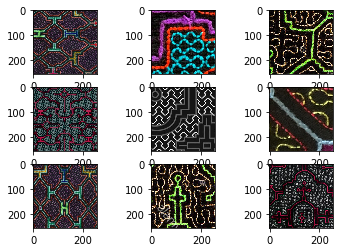

In [6]:
test_indexes = np.random.randint(0,final_count,9)

for i,index in enumerate(test_indexes):
    plt.subplot(3,3,i+1)
    
    plt.imshow(final_imgs[index])
    
plt.show()



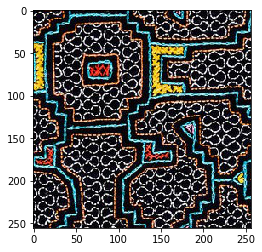

In [7]:
pil_im =  Image.fromarray(np.uint8(final_imgs[100]))

type(pil_im)

plt.imshow(pil_im)

In [8]:
dest_dir = "../../assets/black_assets/augment/"

for i,f_im in enumerate(final_imgs):
    
    #create pillow image
    pil_im = Image.fromarray(np.uint8(f_im))
    
    pil_im.save(dest_dir + str(i)+"_256.jpg", "JPEG", subsampling=0, quality=100)
    
    if i % 250 == 0:
        print("saved",i," augmented images")

saved 0  augmented images
saved 250  augmented images
saved 500  augmented images
saved 750  augmented images
saved 1000  augmented images
saved 1250  augmented images
saved 1500  augmented images
saved 1750  augmented images
saved 2000  augmented images
saved 2250  augmented images
saved 2500  augmented images
saved 2750  augmented images
saved 3000  augmented images
saved 3250  augmented images
saved 3500  augmented images
saved 3750  augmented images
saved 4000  augmented images


In [10]:
def pre_process_augmented_images(source_dir,destination_dir,final_size=64):
    """ takes the images created from the augmentation process
        and resizes them to another power of 2 factor (32x32, or 64x64)
    """
    
    for i,file in enumerate(os.listdir(source_dir)):
        
        with Image.open(source_dir + file) as im:
            
            r_im = im.resize((final_size,final_size), Image.ANTIALIAS)
            
            r_im.save(destination_dir + str(i)+".jpg", "JPEG", subsampling=0, quality=100)
            
        if i % 250 == 0:
            print("saved",i,"images at resolution:",final_size)

size = 64

source = "../../assets/black_assets/augment/"
dest = "../../assets/black_assets/" + str(size) + "/"

pre_process_augmented_images(source,dest,size)

saved 0 images at resolution: 64
saved 250 images at resolution: 64
saved 500 images at resolution: 64
saved 750 images at resolution: 64
saved 1000 images at resolution: 64
saved 1250 images at resolution: 64
saved 1500 images at resolution: 64
saved 1750 images at resolution: 64
saved 2000 images at resolution: 64
saved 2250 images at resolution: 64
saved 2500 images at resolution: 64
saved 2750 images at resolution: 64
saved 3000 images at resolution: 64
saved 3250 images at resolution: 64
saved 3500 images at resolution: 64
saved 3750 images at resolution: 64
saved 4000 images at resolution: 64
